In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import pywt
from scipy.signal import welch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from xgboost import XGBClassifier

In [2]:
import numpy as np
import pywt
from scipy.signal import welch
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class EEGUtil:
    @staticmethod
    def load_data(file_path, column_name='spike hz'):
        """Load EEG data from a CSV file."""
        data = pd.read_csv(file_path)
        signal = data[column_name].values
        return signal

    @staticmethod
    def padding(signal, target_length, mode="constant", constant_value=-1):
        """Pad or truncate signal to the target length with various strategies."""
        signal = np.array(signal)
        current_length = len(signal)
        
        if current_length >= target_length:
            return signal[:target_length]

        padding_size = target_length - current_length

        if mode == "constant":
            return np.pad(signal, (0, padding_size), 'constant', constant_values=constant_value)
        elif mode == "reflect":
            return np.pad(signal, (0, padding_size), 'reflect')
        elif mode == "cyclic":
            return np.pad(signal, (0, padding_size), 'wrap')
        elif mode == "edge":
            return np.pad(signal, (0, padding_size), 'edge')
        elif mode == "random":
            random_padding = np.random.uniform(low=np.min(signal), high=np.max(signal), size=padding_size)
            return np.concatenate((signal, random_padding))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

    @staticmethod
    def wavelet_transform(signal):
        """Perform Wavelet Transform and extract features."""
        coeffs = pywt.wavedec(signal, 'db4', level=5)
        features = []
        for i in range(1, len(coeffs)):
            features.extend([np.mean(coeffs[i]), np.std(coeffs[i])])
        return np.array(features)

    @staticmethod
    def psd_transform(signal, fs=0.2, nperseg=128):
        """Perform Power Spectral Density analysis and extract features."""
        _, psd = welch(signal, fs=fs, nperseg=nperseg)
        return psd

In [3]:
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, target_length=600, strategy='padding', 
                 padding_mode="constant", use_labels=False, augment=False):
        """
        EEG 信号数据集，支持数据增强（随机填充）。

        参数：
        - data_folder: EEG 数据文件夹路径
        - outcome_file: CSV 文件，包含患者 ID 和 outcome（可选）
        - target_length: 目标填充长度
        - strategy: 预处理策略 ('padding', 'wavelet', 'psd')
        - padding_mode: 填充模式 ('constant', 'reflect', ...)
        - use_labels: 是否使用标签
        - augment: 是否启用数据增强（随机填充不同长度）
        """
        self.use_labels = use_labels
        self.data_folder = data_folder
        self.target_length = target_length
        self.strategy = strategy
        self.padding_mode = padding_mode
        self.augment = augment  # 是否启用数据增强

        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

        # 加载标签
        self.outcome_dict = {}
        if use_labels and outcome_file:
            self.outcome_data = pd.read_csv(outcome_file)
            self.outcome_dict = self.outcome_data.set_index('pat_ID')['outcome'].to_dict()
            self.file_list = [f for f in self.file_list if f.split('.')[0] in self.outcome_dict]

        # **现在开始筛选符合 16h 规则的 EEG 数据**
        self.filtered_files = []
        for f in self.file_list:
            file_path = os.path.join(self.data_folder, f)
            signal = EEGUtil.load_data(file_path, column_name='spike hz')

            #if len(signal) < 16 * 12:  # **过滤短于 16h 的数据**
            #    #print(f"Skipping {file_path}: Less than 16h of data ({len(signal)} timestamps)")
            #    continue

            # **截取 16h 后的数据**
            #signal = signal[16 * 12:]  # **跳过前 16h**
            
            self.filtered_files.append((f, signal))  # **存储文件名和处理后的信号**

        print(f"Loaded {len(self.filtered_files)} valid EEG files (filtered from {len(self.file_list)} total)")

        # **统计 Good / Bad Outcome 样本数**
        self.good_outcome_count = sum(1 for f, _ in self.filtered_files if self.get_label(f.split('.')[0]) == 1)
        self.bad_outcome_count = len(self.filtered_files) - self.good_outcome_count

        print(f"Good Outcome: {self.good_outcome_count}, Bad Outcome: {self.bad_outcome_count}")

        # **数据增强：扩展索引**
        self.expanded_indices = []
        for idx, (filename, signal) in enumerate(self.filtered_files):
            patient_id = filename.split('.')[0]
            label = self.get_label(patient_id) if self.use_labels else -1

            if self.augment:
                if self.use_labels:
                    # Good Outcome 10倍，Bad Outcome 2倍
                    if label == 1:
                        repeat_times = 10
                    else:
                        repeat_times = 2
                else:
                    repeat_times = 2  # 无标签数据增强
            else:
                repeat_times = 1  

            self.expanded_indices.extend([idx] * repeat_times)

    def __len__(self):
        return len(self.expanded_indices)

    def __getitem__(self, idx):
        original_idx = self.expanded_indices[idx]  # 获取原始数据索引
        filename = self.file_list[original_idx]
        patient_id = filename.split('.')[0]
        file_path = os.path.join(self.data_folder, filename)
        signal = EEGUtil.load_data(file_path, column_name='spike hz')

        # 获取标签
        label = -1
        if self.use_labels:
            label = self.get_label(patient_id)

        # 进行数据增强（每次都不同）
        if self.augment:
            #print(f"Augmenting sample {idx}")  # **添加调试信息**
            augmented_signal = self.augment_signal(signal)
        else:
            augmented_signal = self.process_signal(signal)

        return torch.tensor(augmented_signal, dtype=torch.float32).unsqueeze(0), label

    def process_signal(self, signal):
        """根据不同策略处理信号"""
        if self.strategy == 'padding':
            return EEGUtil.padding(signal, self.target_length, mode=self.padding_mode)
        elif self.strategy == 'wavelet':
            return EEGUtil.wavelet_transform(signal)
        elif self.strategy == 'psd':
            return EEGUtil.psd_transform(signal)
        else:
            raise ValueError("Invalid processing strategy")

    def augment_signal(self, signal):
        """数据增强：随机前后填充不同长度"""
        original_length = len(signal)
        if original_length >= self.target_length:
            return signal[:self.target_length]

        padding_needed = self.target_length - original_length

        # 限制 left_pad 至少填充 1 个点，避免始终填充在右侧
        left_pad = np.random.randint(1, padding_needed) if padding_needed > 1 else 1  
        right_pad = padding_needed - left_pad  

        augmented_signal = np.pad(signal, (left_pad, right_pad), mode=self.padding_mode)

        # Debug: 打印填充情况
        #print(f"Original Length: {original_length}, Left Pad: {left_pad}, Right Pad: {right_pad}")

        return augmented_signal

    def get_label(self, patient_id):
        """获取样本的标签 (1=Good Outcome, 0=Bad Outcome)"""
        return 1 if self.outcome_dict.get(patient_id, 'Bad Outcome') == 'Good Outcome' else 0

    def compare_data_augmentation(self):
        """Compare the number of samples before and after data augmentation."""
        original_count = len(self.filtered_files)  # 只统计符合16h条件的文件
        augmented_count = len(self.expanded_indices)  # 统计扩增后的样本数量

        print(f"Data count before augmentation: {original_count}")
        print(f"Data count after augmentation: {augmented_count}")
        print(f"Augmentation ratio: {augmented_count / original_count:.2f}x")

        if self.use_labels:
            # 统计 Good Outcome 和 Bad Outcome 在原始数据中的数量（基于 filtered_files）
            good_outcome_original = sum(1 for f, _ in self.filtered_files if self.get_label(f.split('.')[0]) == 1)
            bad_outcome_original = original_count - good_outcome_original  # 剩下的就是 Bad Outcome

            # 统计 Good Outcome 和 Bad Outcome 在扩增后的数量
            good_outcome_augmented = sum(1 for idx in self.expanded_indices if self.get_label(self.filtered_files[idx][0].split('.')[0]) == 1)
            bad_outcome_augmented = augmented_count - good_outcome_augmented  # 剩下的就是 Bad Outcome

            print(f"Good Outcome before augmentation: {good_outcome_original}, after augmentation: {good_outcome_augmented}")
            print(f"Bad Outcome before augmentation: {bad_outcome_original}, after augmentation: {bad_outcome_augmented}")

        return original_count, augmented_count

In [4]:
initial_channels = 128
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNEncoder, self).__init__()
        self.latent_dim = latent_dim

        layers = [
            nn.Conv1d(1, initial_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        ]

        in_channels = initial_channels
        for i in range(3):  # 3 more layers to make 4 in total
            out_channels = in_channels // 2
            layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)
        self.fc_mean = nn.Linear(in_channels * seq_length, latent_dim)
        self.fc_logvar = nn.Linear(in_channels * seq_length, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

class CNNDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, initial_channels // 8 * seq_length)  # Match the output channel of the encoder

        layers = [nn.LeakyReLU()]
        in_channels = initial_channels // 8
        for i in range(3):
            out_channels = in_channels * 2
            layers.extend([
                nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels
        
        # Remove the last LeakyReLU and add a final ConvTranspose to match the Encoder's starting channel
        layers.pop()
        layers.append(nn.ConvTranspose1d(in_channels, 1, kernel_size=3, stride=1, padding=1))

        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), initial_channels // 8, seq_length)
        x = self.decoder(x)
        return F.leaky_relu(x)


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = CNNEncoder(latent_dim)
        self.decoder = CNNDecoder(latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mean, logvar
    
    def get_embedding(self, x):
        self.eval()
        with torch.no_grad():
            mean, logvar = self.encoder(x)
            z = self.reparameterize(mean, logvar)
        return z

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [5]:
def train(model, dataloader, optimizer, criterion, alpha, kl_loss_enabled=True):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for data, label in dataloader:  # We don't use the labels during unsupervised training for VAE
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass through the model
        reconstruction, mean, logvar = model(data)

        # Compute the reconstruction loss (mean squared error)
        recon_loss = criterion(reconstruction, data)

        # Compute the KL divergence loss
        kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

        # Combine the losses
        loss = recon_loss + (alpha * kl_loss if kl_loss_enabled else 0)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)  # Accumulate the total loss for this batch

    epoch_loss = running_loss / len(dataloader.dataset)  # Calculate the average loss per sample
    return epoch_loss


def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for data, label in dataloader:  # 注意：解包数据，将信号和标签分别取出
            data = data.to(device)
            reconstruction, _, _ = model(data)
            loss = criterion(reconstruction, data)
            running_loss += loss.item() * data.size(0)
    return running_loss / len(dataloader.dataset)

def get_latent_variables(model, dataloader):
    model.eval()
    all_latent_vars = []
    with torch.no_grad():
        for data, label  in dataloader:
            data = data.to(device)
            _, mean, _ = model(data)
            all_latent_vars.append(mean.detach().cpu())
    return torch.cat(all_latent_vars)

In [6]:
def extract_latent_features(vae_model, dataset):
    latent_features = []
    labels = []

    for i in range(len(dataset)):
        signal, label = dataset[i]  # 从数据集中获取信号和标签

        # 将信号放入设备
        signal = signal.unsqueeze(0).to(device)  # 增加 batch 维度

        # 获取潜在表示
        with torch.no_grad():
            latent_vector = vae_model.get_embedding(signal).cpu().numpy()
        latent_features.append(latent_vector.flatten())

        
        
        labels.append(label)

    return np.array(latent_features), np.array(labels)

import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_augmented_samples(dataset, num_samples=5):
    """
    Randomly selects num_samples augmented EEG samples and visualizes their waveforms 
    with the x-axis starting from 16 hours.

    Parameters:
    - dataset: An instance of EEGDataset
    - num_samples: Number of samples to visualize
    """
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 2 * num_samples))

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)  # Randomly select an index
        sample, label = dataset[idx]  # Retrieve the augmented data
        sample = sample.squeeze(0).numpy()  # Remove the channel dimension
        
        # Compute the time axis in hours, ensuring the same length as sample
        start_time = 16  # Start at 16 hours
        time_axis = np.linspace(start_time, start_time + (len(sample) - 1) * 5 / 60, len(sample))

        # Plot the EEG signal
        axes[i].plot(time_axis, sample, label=f"Sample {i+1} (Label: {label})", color='b')
        axes[i].set_title(f"Sample {i+1} (Label: {label})")
        axes[i].set_xlabel("Time (hours)")
        axes[i].set_ylabel("Amplitude")
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

Loaded 298 valid EEG files (filtered from 298 total)
Good Outcome: 52, Bad Outcome: 246
Data count before augmentation: 298
Data count after augmentation: 1012
Augmentation ratio: 3.40x
Good Outcome before augmentation: 52, after augmentation: 520
Bad Outcome before augmentation: 246, after augmentation: 492


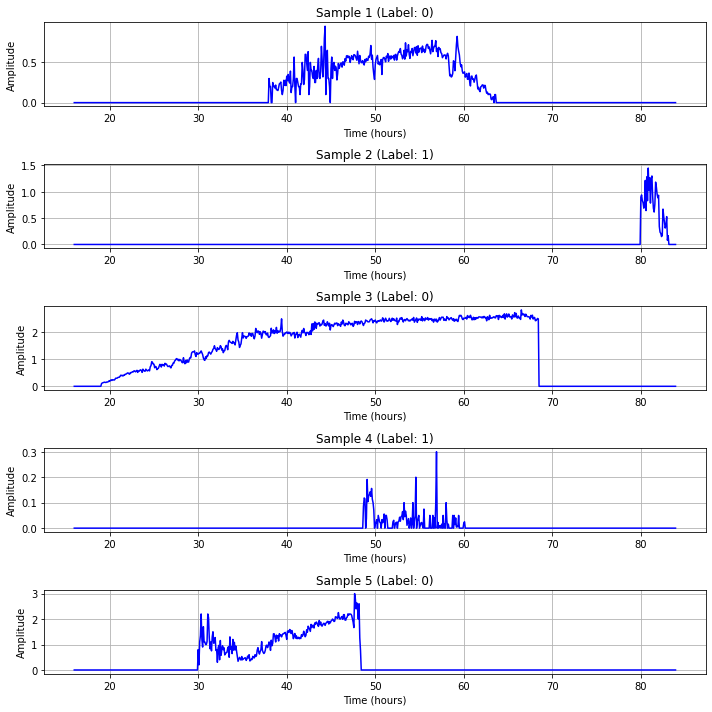

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd

# 設置設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超參數設置
latent_dim = 7  # 潛在空間的維度
initial_channels = 128  # CNN 的初始通道數
#seq_length = 68*12-16*12# 填充或截斷的序列長度 此處設為最長
seq_length = 68*12
batch_size = 32
epochs = 100
alpha = 1e-6  # KL 損失的權重
patience = 5  # 定义在多少个 epoch 不改善后停止训练
padding_method='constant'# 使用反射填充
is_augment=True

# 定義數據文件夾路徑
data_folder = '5min_smoothed_data/'  # 替換為你實際的數據文件夾路徑
valid_outcome_data = 'valid_patients_outcome.csv'

# 创建 EEG 数据集（训练 VAE 时不使用标签）
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    target_length=seq_length,
    strategy='padding',
    padding_mode=padding_method,
    use_labels=True,  # 使用标签以计算类别增强
    augment=is_augment      # 启用数据增强
)

# 输出数据增强前后的统计信息
eeg_dataset.compare_data_augmentation()
visualize_augmented_samples(eeg_dataset, num_samples=5)  # 随机可视化 5 个样本



Epoch 1/100, Train Loss: 0.4239, Test Loss: 0.2841
Epoch 2/100, Train Loss: 0.2246, Test Loss: 0.2430
Epoch 3/100, Train Loss: 0.1910, Test Loss: 0.2113
Epoch 4/100, Train Loss: 0.1727, Test Loss: 0.2077
Epoch 5/100, Train Loss: 0.1579, Test Loss: 0.1824
Epoch 6/100, Train Loss: 0.1375, Test Loss: 0.1563
Epoch 7/100, Train Loss: 0.1211, Test Loss: 0.1363
Epoch 8/100, Train Loss: 0.1041, Test Loss: 0.1227
Epoch 9/100, Train Loss: 0.0932, Test Loss: 0.1178
Epoch 10/100, Train Loss: 0.1200, Test Loss: 0.2248
Epoch 11/100, Train Loss: 0.1899, Test Loss: 0.1300
Epoch 12/100, Train Loss: 0.1004, Test Loss: 0.1220
Epoch 13/100, Train Loss: 0.0883, Test Loss: 0.1117
Epoch 14/100, Train Loss: 0.0800, Test Loss: 0.1005
Epoch 15/100, Train Loss: 0.0764, Test Loss: 0.0924
Epoch 16/100, Train Loss: 0.0730, Test Loss: 0.0918
Epoch 17/100, Train Loss: 0.0707, Test Loss: 0.0906
Epoch 18/100, Train Loss: 0.0674, Test Loss: 0.0851
Epoch 19/100, Train Loss: 0.0644, Test Loss: 0.0829
Epoch 20/100, Train L

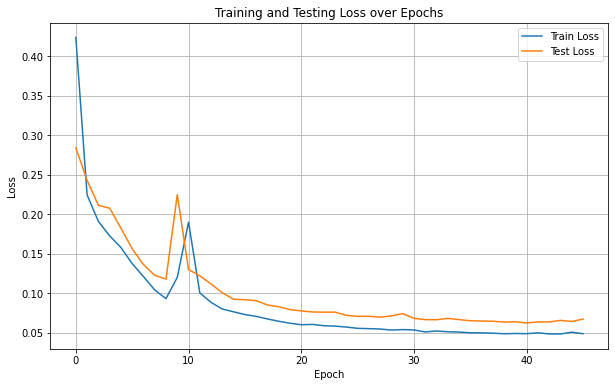

In [9]:
train_size = int(0.8 * len(eeg_dataset))
test_size = len(eeg_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(eeg_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# 定义模型、损失函数和优化器
vae_model = VAE(latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3, weight_decay=1e-4)

# 训练和测试损失列表，用于绘制曲线
train_losses = []
test_losses = []

# 早停相关变量
best_test_loss = float('inf')
epochs_no_improve = 0

# 训练循环
for epoch in range(epochs):
    train_loss = train(vae_model, train_loader, optimizer, criterion, alpha)
    test_loss = test(vae_model, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    # 检查早停条件
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print("Validation loss has not improved for {} epochs. Early stopping...".format(patience))
        break
        
        
# 绘制训练和测试损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Sample 1 shape: (624,), Reconstruction shape: (624,)
Sample 1 range: 0.36666667461395264 to 2.507692337036133
Reconstruction 1 range: 0.4946252703666687 to 2.6744720935821533
Sample 2 shape: (624,), Reconstruction shape: (624,)
Sample 2 range: 0.0 to 2.700000047683716
Reconstruction 2 range: -0.00711011653766036 to 1.4093477725982666
Sample 3 shape: (624,), Reconstruction shape: (624,)
Sample 3 range: 0.0 to 0.2857142984867096
Reconstruction 3 range: -0.003714353311806917 to 0.08065563440322876
Sample 4 shape: (624,), Reconstruction shape: (624,)
Sample 4 range: 0.0 to 0.8880000114440918
Reconstruction 4 range: -0.0030970722436904907 to 0.21391808986663818
Sample 5 shape: (624,), Reconstruction shape: (624,)
Sample 5 range: 0.0 to 2.700000047683716
Reconstruction 5 range: -0.007189151365309954 to 2.6758053302764893


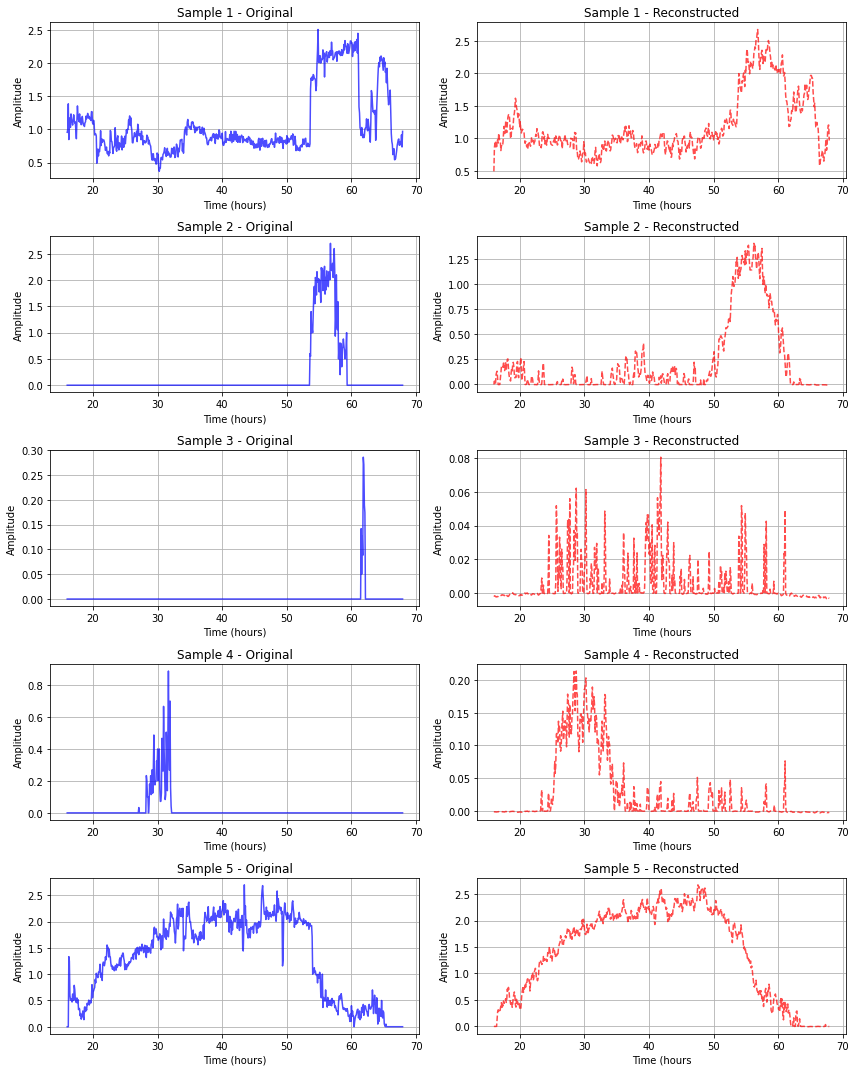

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

def visualize_reconstruction(vae_model, dataset, num_samples=5):
    """
    Randomly selects num_samples EEG signals and visualizes them alongside their reconstructed versions.
    Each sample is shown in a subplot with original and reconstructed signals stacked for direct comparison.

    Parameters:
    - vae_model: Trained VAE model
    - dataset: Instance of EEGDataset
    - num_samples: Number of samples to visualize
    """
    vae_model.eval()  # Set model to evaluation mode
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 3 * num_samples))  # 2 columns for before & after comparison
    
    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)  # Randomly select a sample index
        sample, _ = dataset[idx]  # Retrieve EEG signal (already preprocessed)
        sample = sample.unsqueeze(0).to(device)  # Add batch dimension and move to device
        
        # Obtain reconstructed signal
        with torch.no_grad():
            reconstruction, _, _ = vae_model(sample)
        
        sample = sample.squeeze().cpu().numpy()  # Ensure it's 1D
        reconstruction = reconstruction.squeeze().cpu().numpy()
        
        # Debugging: Check if data is valid
        print(f"Sample {i+1} shape: {sample.shape}, Reconstruction shape: {reconstruction.shape}")
        print(f"Sample {i+1} range: {sample.min()} to {sample.max()}")
        print(f"Reconstruction {i+1} range: {reconstruction.min()} to {reconstruction.max()}")
        
        # Compute time axis (starting from 16h, with 5-minute intervals per point)
        start_time = 16  # Start at 16 hours
        time_axis = np.linspace(start_time, start_time + (len(sample) - 1) * 5 / 60, len(sample))
        
        # Ensure time_axis and sample length match
        assert len(time_axis) == len(sample), "Time axis length mismatch!"
        
        # Plot original signal in the left column
        axes[i, 0].plot(time_axis, sample, color='b', alpha=0.7)
        axes[i, 0].set_title(f"Sample {i+1} - Original")
        axes[i, 0].set_xlabel("Time (hours)")
        axes[i, 0].set_ylabel("Amplitude")
        axes[i, 0].grid(True)
        
        # Plot reconstructed signal in the right column
        axes[i, 1].plot(time_axis, reconstruction, color='r', linestyle='dashed', alpha=0.7)
        axes[i, 1].set_title(f"Sample {i+1} - Reconstructed")
        axes[i, 1].set_xlabel("Time (hours")
        axes[i, 1].set_ylabel("Amplitude")
        axes[i, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig("debug_plot.png")  # Save the plot for debugging
    plt.show()

# Call the visualization function (assuming vae_model and eeg_dataset are defined)
visualize_reconstruction(vae_model, eeg_dataset, num_samples=5)

In [80]:
# 创建 EEG 数据集和数据加载器
# 创建 EEG 数据集并使用不同的填充模式
# 如果只想读取有标签的数据
# 创建 EEG 数据集（训练 VAE 时不使用标签）
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    target_length=seq_length,
    strategy='padding',
    padding_mode=padding_method,
    use_labels=True,  # 使用标签以计算类别增强
    augment=is_augment      # 启用数据增强
)
eeg_dataset.compare_data_augmentation()
# 提取潜在特征和标签
latent_features, labels = extract_latent_features(vae_model, eeg_dataset)

Loaded 168 valid EEG files (filtered from 298 total)
Good Outcome: 16, Bad Outcome: 152
Data count before augmentation: 168
Data count after augmentation: 464
Augmentation ratio: 2.76x
Good Outcome before augmentation: 16, after augmentation: 160
Bad Outcome before augmentation: 152, after augmentation: 304


In [82]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# 确保 labels 是 numpy 数组
labels = np.array(labels)

# 使用分层划分进行训练和测试集划分
X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.3, stratify=labels, random_state=42)

print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

Class distribution before split: Counter({0: 394, 1: 70})
Training set class distribution: Counter({0: 275, 1: 49})
Testing set class distribution: Counter({0: 119, 1: 21})
Training set class distribution: [275  49]
Testing set class distribution: [119  21]


In [78]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # 设定不使用标签编码
xgb_model.fit(X_train, y_train)

# 9. 预测并评估模型
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


print(f"Accuracy of XGB on latent features: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy of XGB on latent features: 0.9000

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       119
           1       0.71      0.57      0.63        21

    accuracy                           0.90       140
   macro avg       0.82      0.76      0.79       140
weighted avg       0.89      0.90      0.90       140


Confusion Matrix:
[[114   5]
 [  9  12]]


In [79]:
# 创建并训练 SVM 模型
svm_model = SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)

# 预测并评估模型
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of SVM on latent features: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy of SVM on latent features: 0.5000

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.45      0.60       119
           1       0.20      0.81      0.33        21

    accuracy                           0.50       140
   macro avg       0.57      0.63      0.46       140
weighted avg       0.82      0.50      0.56       140


Confusion Matrix:
[[53 66]
 [ 4 17]]


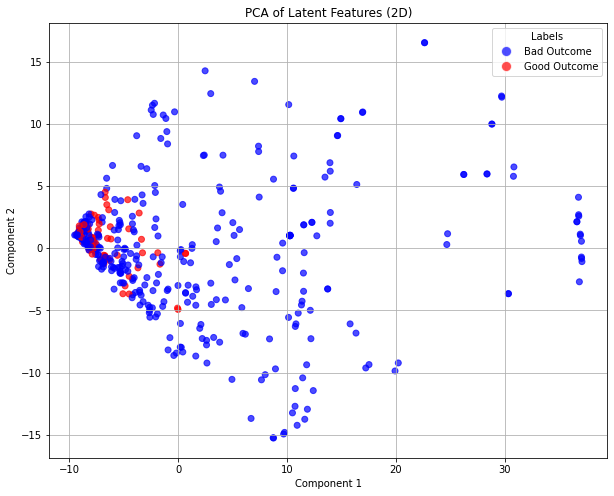

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D


def visualize_latent_space(latent_features, labels, method='pca', dimensions=2):
    """
    将潜在特征降维并可视化，支持二维或三维图形。
    
    参数：
    - latent_features: 2D numpy array，形状为 (样本数, 特征维度)
    - labels: 1D numpy array，样本标签
    - method: str, 降维方法 ('pca' 或 'tsne')
    - dimensions: int, 降维到2维或3维 (2或3)
    """
    if dimensions not in [2, 3]:
        raise ValueError("Dimensions must be 2 or 3.")

    # 降维
    if method == 'pca':
        reducer = PCA(n_components=dimensions)
        reduced_features = reducer.fit_transform(latent_features)
        title = f"PCA of Latent Features ({dimensions}D)"
    elif method == 'tsne':
        reducer = TSNE(n_components=dimensions, random_state=42)
        reduced_features = reducer.fit_transform(latent_features)
        title = f"t-SNE of Latent Features ({dimensions}D)"
    else:
        raise ValueError("Method should be 'pca' or 'tsne'.")

    # 可视化
    if dimensions == 2:
        %matplotlib inline
        # 二维散点图
        plt.figure(figsize=(10, 8))
        color_map = {0: 'blue', 1: 'red'}
        label_map = {0: 'Bad Outcome', 1: 'Good Outcome'}
        colors = [color_map[label] for label in labels]
        scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, alpha=0.7)
        
        # 创建自定义图例
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
        plt.legend(handles=handles, title="Labels")
        plt.title(title)
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.grid(True)
        plt.show()

        
    elif dimensions == 3:
        %matplotlib notebook
        # 三维散点图
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        color_map = {0: 'blue', 1: 'red'}
        label_map = {0: 'Bad Outcome', 1: 'Good Outcome'}
        colors = [color_map[label] for label in labels]

        scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=colors, alpha=0.7)

        # 创建自定义图例
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
        ax.legend(handles=handles, title="Labels")
        ax.set_title(title)
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_zlabel("Component 3")

        # 显示交互式图形
        plt.show()

        
        
# 调用可视化函数

visualize_latent_space(latent_features, labels, method='pca', dimensions=2) 
# 可设置'dimensions=2'或'dimensions=3'





In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# 列出所有分类器
classifiers = {
    'SVM': SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# 使用分层划分进行训练和测试集划分
X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.3, stratify=labels, random_state=42)

# 循环遍历每个分类器进行训练和评估
for name, classifier in classifiers.items():
    # 创建并训练分类器
    classifier.fit(X_train, y_train)

    # 预测并评估模型
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # 打印分类结果
    print(f"Classifier: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("=" * 50)  # 分隔线

Classifier: SVM
Accuracy: 0.6645

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       148
           1       0.65      0.76      0.70       156

    accuracy                           0.66       304
   macro avg       0.67      0.66      0.66       304
weighted avg       0.67      0.66      0.66       304


Confusion Matrix:
[[ 83  65]
 [ 37 119]]
Classifier: Random Forest
Accuracy: 0.8520

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       148
           1       0.87      0.84      0.85       156

    accuracy                           0.85       304
   macro avg       0.85      0.85      0.85       304
weighted avg       0.85      0.85      0.85       304


Confusion Matrix:
[[128  20]
 [ 25 131]]
Classifier: Logistic Regression
Accuracy: 0.6513

Classification Report:
              precision    recall  f1-score   support

          


=== Experiment with Padding Mode: constant ===
Epoch 1/100, Train Loss: 1.1426, Test Loss: 0.9466
Epoch 2/100, Train Loss: 0.9198, Test Loss: 0.7692
Epoch 3/100, Train Loss: 0.5170, Test Loss: 0.4085
Epoch 4/100, Train Loss: 0.3940, Test Loss: 0.3714
Epoch 5/100, Train Loss: 0.3895, Test Loss: 0.3670
Epoch 6/100, Train Loss: 0.3622, Test Loss: 0.3556
Epoch 7/100, Train Loss: 0.3471, Test Loss: 0.3465
Epoch 8/100, Train Loss: 0.3421, Test Loss: 0.3412
Epoch 9/100, Train Loss: 0.3399, Test Loss: 0.3402
Epoch 10/100, Train Loss: 0.3381, Test Loss: 0.3385
Epoch 11/100, Train Loss: 0.3365, Test Loss: 0.3369
Epoch 12/100, Train Loss: 0.3344, Test Loss: 0.3349
Epoch 13/100, Train Loss: 0.3314, Test Loss: 0.3308
Epoch 14/100, Train Loss: 0.3256, Test Loss: 0.3222
Epoch 15/100, Train Loss: 0.3131, Test Loss: 0.3053
Epoch 16/100, Train Loss: 0.2989, Test Loss: 0.2881
Epoch 17/100, Train Loss: 0.2816, Test Loss: 0.2619
Epoch 18/100, Train Loss: 0.2543, Test Loss: 0.2579
Epoch 19/100, Train Loss:

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.



=== Results for Padding Mode: constant ===
Accuracy: 0.7833

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.20      0.10      0.13        10

    accuracy                           0.78        60
   macro avg       0.52      0.51      0.50        60
weighted avg       0.73      0.78      0.75        60


Confusion Matrix:
[[46  4]
 [ 9  1]]

=== Experiment with Padding Mode: reflect ===
Epoch 1/100, Train Loss: 0.2760, Test Loss: 0.0898
Epoch 2/100, Train Loss: 0.1316, Test Loss: 0.0777
Epoch 3/100, Train Loss: 0.1222, Test Loss: 0.0758
Epoch 4/100, Train Loss: 0.1193, Test Loss: 0.0748
Epoch 5/100, Train Loss: 0.1178, Test Loss: 0.0741
Epoch 6/100, Train Loss: 0.1168, Test Loss: 0.0733
Epoch 7/100, Train Loss: 0.1147, Test Loss: 0.0745
Epoch 8/100, Train Loss: 0.1128, Test Loss: 0.0715
Epoch 9/100, Train Loss: 0.1091, Test Loss: 0.0804
Epoch 10/100, Train Loss: 0.1121, Test Loss:

Epoch 10/100, Train Loss: 0.1419, Test Loss: 0.1672
Epoch 11/100, Train Loss: 0.1398, Test Loss: 0.1654
Epoch 12/100, Train Loss: 0.1387, Test Loss: 0.1663
Epoch 13/100, Train Loss: 0.1374, Test Loss: 0.1616
Epoch 14/100, Train Loss: 0.1346, Test Loss: 0.1657
Epoch 15/100, Train Loss: 0.1364, Test Loss: 0.1768
Epoch 16/100, Train Loss: 0.1408, Test Loss: 0.1733
Epoch 17/100, Train Loss: 0.1361, Test Loss: 0.1567
Epoch 18/100, Train Loss: 0.1301, Test Loss: 0.1548
Epoch 19/100, Train Loss: 0.1280, Test Loss: 0.1545
Epoch 20/100, Train Loss: 0.1276, Test Loss: 0.1523
Epoch 21/100, Train Loss: 0.1264, Test Loss: 0.1513
Epoch 22/100, Train Loss: 0.1261, Test Loss: 0.1533
Epoch 23/100, Train Loss: 0.1266, Test Loss: 0.1537
Epoch 24/100, Train Loss: 0.1252, Test Loss: 0.1514
Epoch 25/100, Train Loss: 0.1241, Test Loss: 0.1502
Epoch 26/100, Train Loss: 0.1249, Test Loss: 0.1486
Epoch 27/100, Train Loss: 0.1227, Test Loss: 0.1488
Epoch 28/100, Train Loss: 0.1226, Test Loss: 0.1504
Epoch 29/100

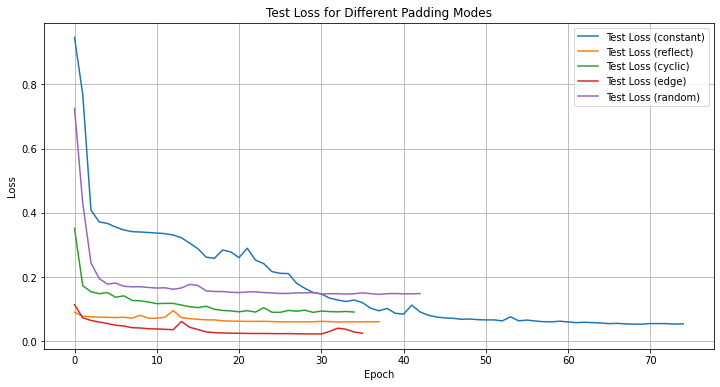


Final Classification Accuracy for Each Padding Mode:
Constant Padding: Accuracy = 0.7833
Reflect Padding: Accuracy = 0.8000
Cyclic Padding: Accuracy = 0.7833
Edge Padding: Accuracy = 0.8333
Random Padding: Accuracy = 0.7833


In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# 定义不同的填充策略
padding_modes = ["constant", "reflect", "cyclic", "edge", "random"]

# 存储每种策略的实验结果
results = {mode: {"train_losses": [], "test_losses": [], "accuracy": None, "classification_report": None, "confusion_matrix": None} for mode in padding_modes}

# 超参数设置
latent_dim = 7
seq_length = 1139
batch_size = 32
epochs = 100
alpha = 1e-6
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据文件路径
data_folder = '5min_smoothed_data/'
outcome_file = 'valid_patients_outcome.csv'

for mode in padding_modes:
    print(f"\n=== Experiment with Padding Mode: {mode} ===")
    
    # Step 1: 数据加载与处理
    eeg_dataset = EEGDataset(data_folder, outcome_file, target_length=seq_length, strategy='padding', padding_mode=mode, use_labels=False)
    train_size = int(0.8 * len(eeg_dataset))
    test_size = len(eeg_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(eeg_dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Step 2: 定义模型并训练
    vae_model = VAE(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(vae_model.parameters(), lr=1e-3, weight_decay=1e-4)

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        train_loss = train(vae_model, train_loader, optimizer, criterion, alpha)
        test_loss = test(vae_model, test_loader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        # 早停机制
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping after {patience} epochs without improvement.")
            break
    
    results[mode]["train_losses"] = train_losses
    results[mode]["test_losses"] = test_losses

    # Step 3: 提取潜在特征和标签
    eeg_dataset = EEGDataset(data_folder, outcome_file, target_length=seq_length, strategy='padding', padding_mode=mode, use_labels=True)
    latent_features, labels = extract_latent_features(vae_model, eeg_dataset)

    # Step 4: 划分训练集和测试集（分类任务）
    X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.2, random_state=42, stratify=labels)

    # Step 5: 训练 XGBoost 分类器
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgb_model.fit(X_train, y_train)

    # Step 6: 测试并评估分类器
    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[mode]["accuracy"] = accuracy
    results[mode]["classification_report"] = class_report
    results[mode]["confusion_matrix"] = conf_matrix

    print(f"\n=== Results for Padding Mode: {mode} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)

# 绘制各填充模式的测试损失曲线
plt.figure(figsize=(12, 6))
for mode in padding_modes:
    plt.plot(results[mode]["test_losses"], label=f'Test Loss ({mode})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss for Different Padding Modes')
plt.legend()
plt.grid(True)
plt.show()

# 打印所有填充模式的最终分类精度
print("\nFinal Classification Accuracy for Each Padding Mode:")
for mode in padding_modes:
    print(f"{mode.capitalize()} Padding: Accuracy = {results[mode]['accuracy']:.4f}")